## Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor 
import warnings
warnings.filterwarnings("ignore")

## Reading all the tables

In [2]:
holiday = pd.read_parquet('data/holidays_events.parquet.gzip')
oil = pd.read_parquet('data/oil.parquet.gzip')
sample = pd.read_parquet('data/sample_submission.parquet.gzip')
store = pd.read_parquet('data/stores.parquet.gzip')
test = pd.read_parquet('data/test.parquet.gzip')
train = pd.read_parquet('data/train.parquet.gzip')
trans = pd.read_parquet('data/transactions.parquet.gzip')

# Merging the data to form a Dataset
df = pd.merge(train, holiday, on='date', how='left')
df = pd.merge(df, oil, on='date', how='left')
df = pd.merge(df, trans, on=['date','store_nbr'], how='left')
df = pd.merge(df, store, on='store_nbr', how='left')

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
# df['weekday'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter

# Creating a function to convert Date into Float datatype
#It takes the data in the date and time format and converts into float datatype
def dt64_to_float(dt64):
    year = dt64.astype('M8[Y]')
    days = (dt64 - year).astype('timedelta64[D]')
    year_next = year + np.timedelta64(1, 'Y')
    days_of_year = (year_next.astype('M8[D]') - year.astype('M8[D]')
                    ).astype('timedelta64[D]')
    dt_float = 1970 + year.astype(float) + days / (days_of_year)
    return dt_float


df['date_float'] = dt64_to_float(df['date'].to_numpy())

In [3]:
df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
type_x          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
transactions     249117
city                  0
state                 0
type_y                0
cluster               0
year                  0
month                 0
week                  0
quarter               0
date_float            0
dtype: int64

### Handling the missing values and filling it with most frequent Item

In [4]:
def miss_val():
    x=df['type_x'].value_counts()
    x=x.index[0]
    df['type_x'].fillna(x,inplace=True)
    locale_1=df['locale'].value_counts()
    locale_name_1=locale_1.index[0]
    df['locale'].fillna(locale_1,inplace=True)
    locale_name_1=df['locale_name'].value_counts()
    locale_name_1=locale_name_1.index[0]
    df['locale_name'].fillna(locale_name_1,inplace=True)
    desc=df['description'].value_counts()
    desc=desc.index[0]
    df['description'].fillna(desc,inplace=True)
    transfer=df['transferred'].value_counts()
    transfer=transfer.index[0]
    df['transferred'].fillna(transfer,inplace=True)
    dcoil=df['dcoilwtico'].value_counts()
    dcoil=dcoil.index[0]
    df['dcoilwtico'].fillna(dcoil,inplace=True)
    transac=df['transactions'].value_counts()
    transac=transac.index[0]
    df['transactions'].fillna(transac,inplace=True)
    locale_1=df['locale'].value_counts()
    locale_1=locale_1.index[0]
    df['locale'].fillna(locale_1,inplace=True)
    locale_1=df['locale_name'].value_counts()
    locale_1=locale_1.index[0]
    df['locale_name'].fillna(locale_1,inplace=True)
    

### Enconding the Catergorical Features in the dataset and modeling

In [5]:
def enc_and_modeling():
    #Encoding all categorical data and ecoding with the lables form 1 to 5
    df['type_x']=df['type_x'].map({'Holiday':1, 'Work Day':5, 'Additional':3, 'Event':2, 'Transfer':4, 'Bridge':6})

    #Encoding all categorical data and ecoding with the lables form 1 to 3
    df['locale']=df['locale'].map({'National':3, 'Local':1, 'Regional':2})
    loc=df['locale_name'].unique().tolist()
    #Encoding all location names and ecoding with the lables form 1 to 23
    loc_dic={y:x for x,y in enumerate(loc)}
    df['locale_name']=df['locale_name'].map(loc_dic)
    print("\nCategorical feature 'Locale_name' has been encoded successfully\n")
    df['transferred']=df['transferred'].map({False:0,True:1})
    #Encoding all location names and ecoding with the lables form 0 to 32
    fam=df['family'].unique().tolist()
    fam_dict=dict(enumerate(fam))
    print('\n',fam_dict)
    fam_dict={y:x for x,y in fam_dict.items()}
    df['family']=df['family'].map(fam_dict)
    print("\nCategorical feature 'family' has been encoded successfully\n")
    city=df['city'].unique()
    city_dic={y:x for x,y in enumerate(city)}
    print('\n',city_dic)
    df['city']=df['city'].map(city_dic)
    print("\nCategorical feature 'City' has been encoded successfully\n")
    State=df['state'].unique()
    State_dic={y:x for x,y in enumerate(State)}
    df['state']=df['state'].map(State_dic)
    print("\nCategorical feature 'State' has been encoded successfully\n")
    type_y=df['type_y'].unique()
    type_dic={y:x for x,y in enumerate(type_y)}
    df['type_y']=df['type_y'].map(type_dic)
    print("\nCategorical feature 'type_y' has been encoded successfully\n")
    print("\nCompletely Encoded Data:\n=========================================================\n")
    print(df.head())
    corr=df.iloc[:,:-1].corr()
    top_features=corr.index
    plt.figure(figsize=(20,20))
    sns.heatmap(df[top_features].corr(),annot=True)
    Column_list=df.columns.tolist()
    print("\nFeatures in the Dataset :\n\n",Column_list)
    print("\nDropped Features are :\n================================ \nstore_nbr,id,description")
    
    modeling(df)

In [6]:
def modeling(df):
    Independent_features=[ 'family', 'sales', 'onpromotion', 'type_x', 'locale', 'locale_name', 'transferred', 'transactions', 'city', 'state', 'type_y', 'cluster','date_float']
    X=df[[ 'family', 'sales', 'onpromotion', 'type_x', 'locale', 'locale_name', 'transferred', 'transactions', 'city', 'state', 'type_y', 'cluster','date_float']]
    print("\nInependent Features:\n====================================\n",X.columns)
    y=df['sales']
    print("\nDependent Features:\n==============================\nSales")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 28)
    
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))
    
    RFR = RandomForestRegressor(n_estimators =5, random_state = 0)
    # Fitting the Random Forest Regression model to the data
    RFR.fit(X_train, y_train)
    print("\nAccuracy of Random Forest Regressor :\n===================================\n",RFR.score(X_test,y_test))
    y_pred=RFR.predict(X_test)
    print('\nMean Absolute Error:\n==========================\n', mean_absolute_error(y_test, y_pred))  
    print('\nMean Squared Error:\n==========================\n',mean_squared_error(y_test, y_pred))  
    print('\nRoot Mean Squared Error:\n==========================\n', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('\nR2 Score:\n==========================\n', r2_score(y_test, y_pred))
    
    # Checking accuracy with K fold cross validation
    cv_score = cross_val_score(RFR,X_test,y_test,cv=5)
    print("\n Cross Validtion accuracy of each fold: \n=======================================\n ",cv_score)
    print("\n\n\n Average of the Cross Validation Accuracy:\n=======================================\n",np.average(cv_score))

In [7]:
def final():
    miss_val()
    enc_and_modeling()



Categorical feature 'Locale_name' has been encoded successfully


 {0: 'AUTOMOTIVE', 1: 'BABY CARE', 2: 'BEAUTY', 3: 'BEVERAGES', 4: 'BOOKS', 5: 'BREAD/BAKERY', 6: 'CELEBRATION', 7: 'CLEANING', 8: 'DAIRY', 9: 'DELI', 10: 'EGGS', 11: 'FROZEN FOODS', 12: 'GROCERY I', 13: 'GROCERY II', 14: 'HARDWARE', 15: 'HOME AND KITCHEN I', 16: 'HOME AND KITCHEN II', 17: 'HOME APPLIANCES', 18: 'HOME CARE', 19: 'LADIESWEAR', 20: 'LAWN AND GARDEN', 21: 'LINGERIE', 22: 'LIQUOR,WINE,BEER', 23: 'MAGAZINES', 24: 'MEATS', 25: 'PERSONAL CARE', 26: 'PET SUPPLIES', 27: 'PLAYERS AND ELECTRONICS', 28: 'POULTRY', 29: 'PREPARED FOODS', 30: 'PRODUCE', 31: 'SCHOOL AND OFFICE SUPPLIES', 32: 'SEAFOOD'}

Categorical feature 'family' has been encoded successfully


 {'Quito': 0, 'Cayambe': 1, 'Latacunga': 2, 'Riobamba': 3, 'Ibarra': 4, 'Santo Domingo': 5, 'Guaranda': 6, 'Puyo': 7, 'Ambato': 8, 'Guayaquil': 9, 'Salinas': 10, 'Daule': 11, 'Babahoyo': 12, 'Quevedo': 13, 'Playas': 14, 'Libertad': 15, 'Cuenca': 16, 'Loja': 17

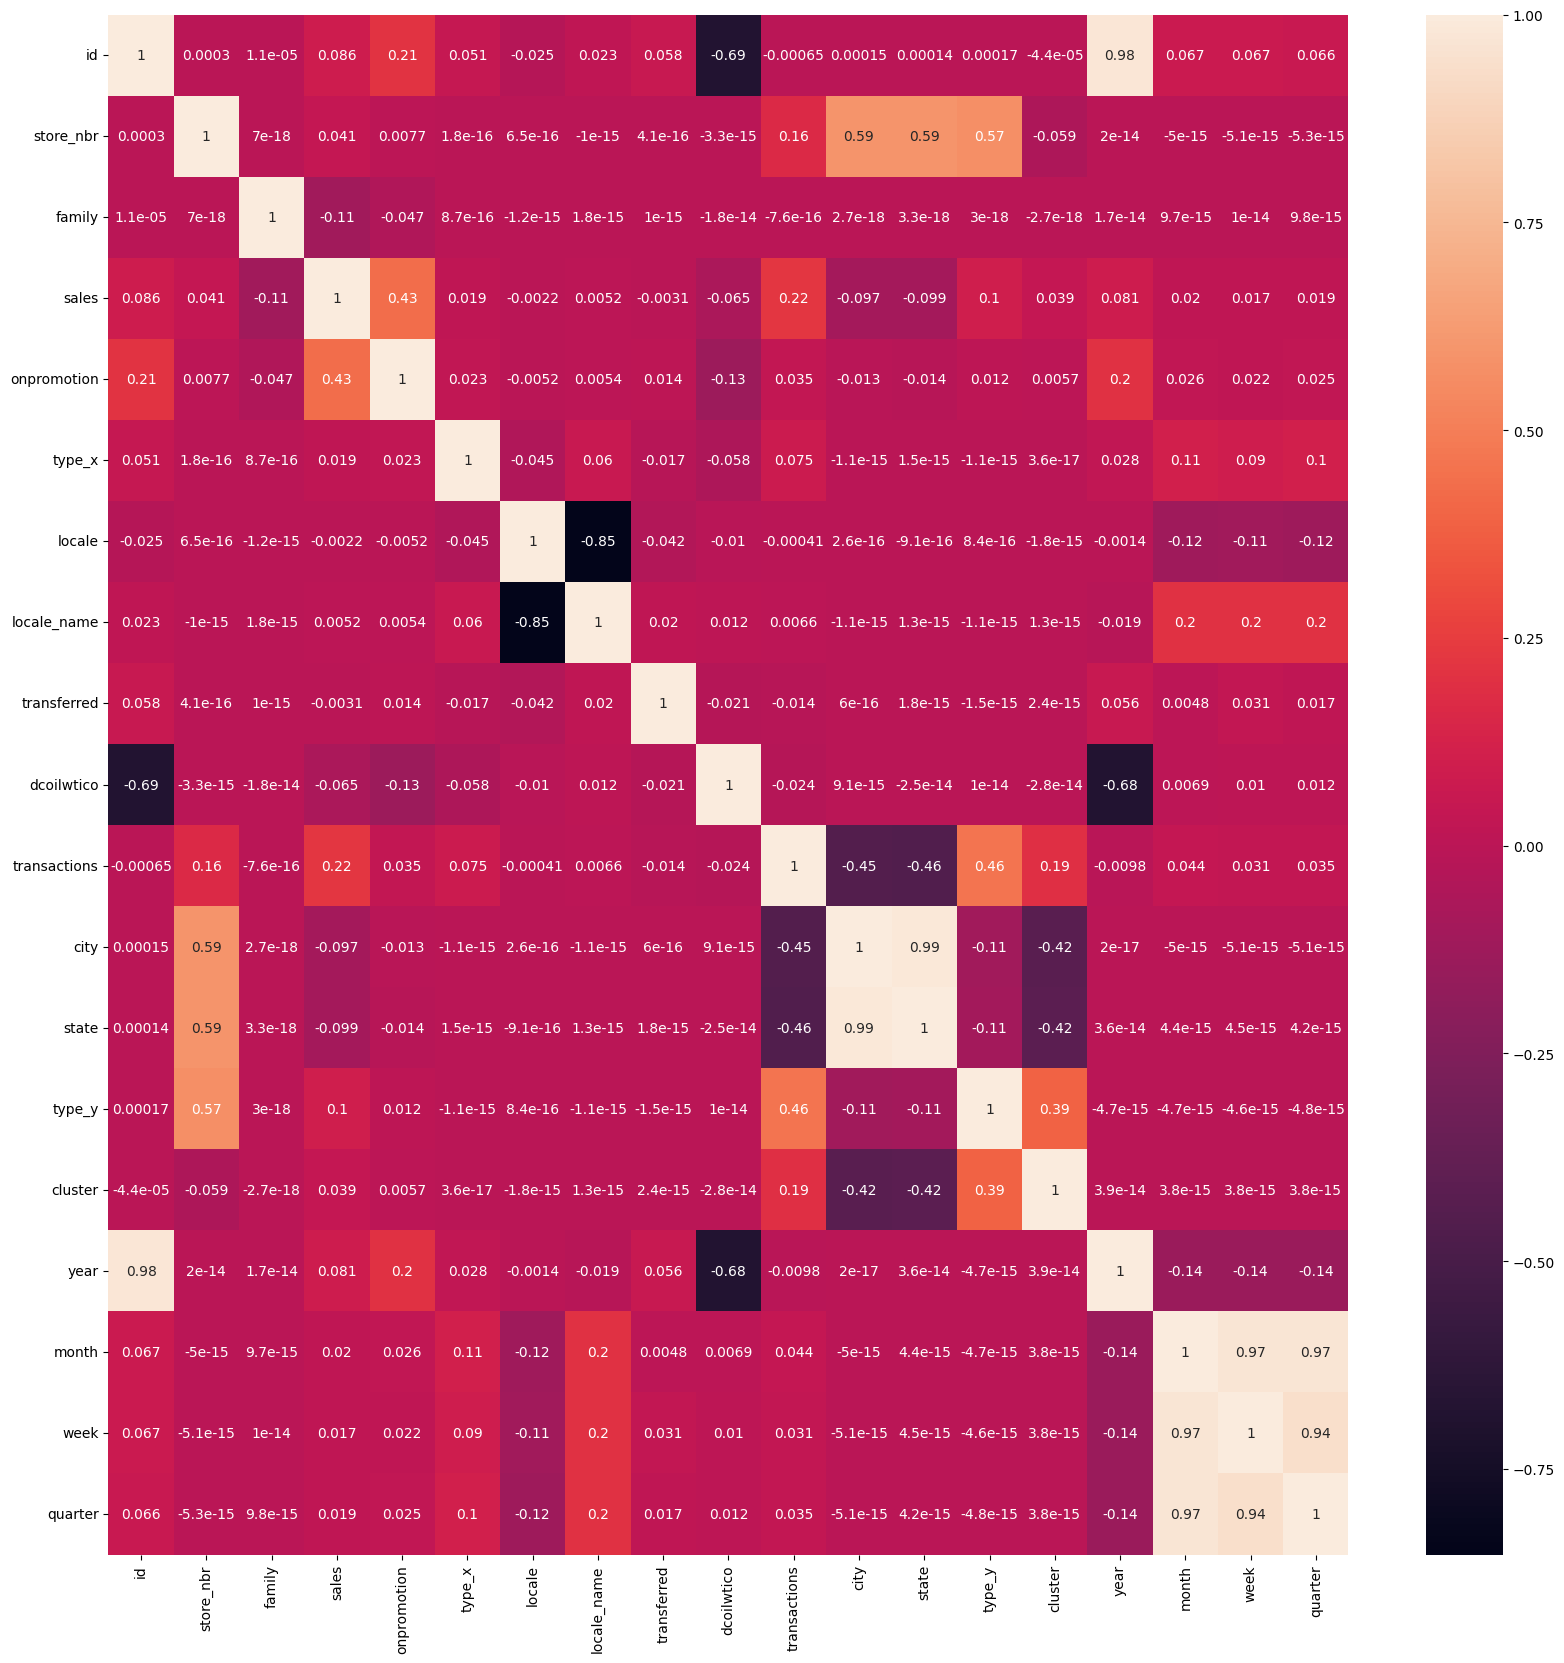

In [8]:
final()